# Clustering on mixed data-types

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). 

Clustering is applied to identify and segment data into groups with similar characteristics. A primary limitation of popular clustering algorithms and approaches is that these are often suitable for either numerical (i.e PCA) or categorical (i.e MCA) data separately.  

In practice, there are several strategies to infer data clusters and segmentation using these popular clustering methods including: 
 - Combining the output of independent PCA and MCA for downstream classification.  
 - Converting and rescaling categorical data and using PCA. This is ok for nominals (ie weak  neutral  strong = -1 0 1) but fails for categories with no relative difference (ie location or industry codes).

In [29]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import tensorflow_data_validation as tfdv

### 1. Case Study: Auto insurance claims [dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data)

In [2]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../_data')
df = pd.read_csv(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim.csv'),low_memory=False,)

# convert object to numerical
df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]] = df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0)

# clean textual classes
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(df.columns,df.dtypes)}

df[:2]

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,MAR,60.0,0,11.0,67349.0,NO,0.0,NO,...,MINIVAN,YES,4461.0,2,NO,3,0.0,18.0,0,HIGHLYURBANURBAN
1,132761049,0,JAN,43.0,0,11.0,91449.0,NO,257252.0,NO,...,MINIVAN,YES,0.0,0,NO,0,0.0,1.0,0,HIGHLYURBANURBAN


***missing data***

In [84]:
df['OCCUPATION'].fillna('OTHER',inplace=True)
for col in ['AGE','YOJ','CAR_AGE']:
    df[col].fillna(df[col].mean(),inplace=True)
    
print(df.isnull().sum()[df.isnull().sum()>0])

Series([], dtype: int64)


### 2. Feature Encoding & Engineering

***what features do we have?***
Having explored I found this [data dictionary](https://rpubs.com/data_feelings/msda_data621_hw4) and following key definitions:
- Bluebook = car re-sale value. 
- MVR_PTS = [MotorVehicleRecordPoints (MVR) ](https://www.wnins.com/losscontrolbulletins/MVREvaluation.pdf) details an individual’s past driving history indicating violations and accidents over a specified period
- TIF = Time In Force / customer lifetime
- YOJ = years in job
- CLM_FRQ = # of claims in past 5 years
- OLDCLAIM = sum $ of claims in past 5 years

In [85]:
# copy df
tdf = df.copy()

In [86]:
feat_id = ['ID']
feat_account = ['KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
                'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION','URBANICITY','TIF',]
feat_car = [ 'TRAVTIME', 'CAR_USE','MVR_PTS','BLUEBOOK','CAR_TYPE', 'RED_CAR','REVOKED','CAR_AGE',]
feat_claims = ['OLDCLAIM', 'CLM_FREQ', 'CLAIM_FLAG','CLM_AMT',]

data_meta = pd.DataFrame(tdf.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta[:2]

,name,num
0,URBANICITY,2
1,REVOKED,2


***transform binary variables***

In [87]:
from sklearn.preprocessing import LabelEncoder

In [93]:
le = LabelEncoder()
for feat in data_meta.loc[data_meta['num']<=12,'name'].values:
    tdf[feat] = le.fit_transform(tdf[feat])

In [94]:
Xy = tdf[feat_account+feat_car+feat_claims].copy()

### 2. EDA
- multiple account years (renewals)

### 4. Similarity

[$Gower$ $distance$](https://www.jstor.org/stable/2528823?seq=1) was proposed to measure dissimilarity between subjects with mixed types of variables using the mathematical concept of distance.
- [docs](https://rdrr.io/cran/gower/api)

In [97]:
import gower

# # Example: to find the most similar record to i=0, in rows i=1...i=100
# gower.gower_topn(Xy.iloc[0:1,:], Xy.iloc[1:100,], n = 1)
# Xy.iloc[[0,42],:].T

In [98]:
try: 
    gd = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'))
    print('Gower distances loaded from file.')
except:
    print('Calculating Gower dsitances...5-8 minutes')
    %time gd = gower.gower_matrix(Xy[:])
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'),gd)

Gower distances loaded from file.


### 5. Clustering

In [99]:
# k-mediods python implmentation in scikit-learn-extra
# https://scikit-learn-extra.readthedocs.io/en/latest/install.html
# C++ build tools may be required on windows
# https://www.scivision.dev/python-windows-visual-c-14-required/

# or k-mediods in pyclustering
# https://pypi.org/project/pyclustering/

In [100]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.silhouette import silhouette

In [122]:
k = 3
n = 6000
sample = np.nan_to_num(gd[:n,:n])

In [123]:
# import networkx as nx

# G = nx.from_numpy_matrix(sample)
# edge_list = [i for i in nx.generate_edgelist(G,data=True)]

***Cluster $k=n$***

In [15]:
# initiate k random medoids
# also sets k clusters
initial_medoids = np.random.randint(0,1000,size=3)
kmedoids_instance = kmedoids(sample,initial_medoids, data_type='distance_matrix')

# run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# score
# The silhouette value is a measure of how similar an object
# is to its own cluster compared to other clusters
score = silhouette(data=sample, clusters=clusters,data_type='distance_matrix').process().get_score()

***Cluster using silhouette score to find $max(k)$***
- [visualizer seems to work with paierd list only](https://github.com/annoviko/pyclustering/issues/499)

In [ ]:
# search using silhouette score
# https://codedocs.xyz/annoviko/pyclustering/classpyclustering_1_1cluster_1_1silhouette_1_1silhouette__ksearch.html
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch

search_instance = silhouette_ksearch(sample, kmin=3, kmax=10,
                                     algorithm=silhouette_ksearch_type.KMEDOIDS).process()

amount = search_instance.get_amount()
scores = search_instance.get_scores()
print("Scores: '%s'" % str(scores))

# Create instance of K-Medoids algorithm with optimal settings from search
initial_medoids = np.random.randint(0,n,size=amount)
kmedoids_instance = kmedoids(sample,initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# capture results
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

In [ ]:
len(clusters), sample.shape

# Visualise

In [109]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy[:3000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2809.532434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.034309
[t-SNE] KL divergence after 500 iterations: 0.731554


In [116]:
tsne_df = pd.DataFrame(tsne)

tsne_df['cluster'] = np.nan
for e,k in enumerate(clusters):
    print(e,len(k))
    tsne_df.iloc[k,-1] = e

0 2996
1 1
2 1
3 1
4 1


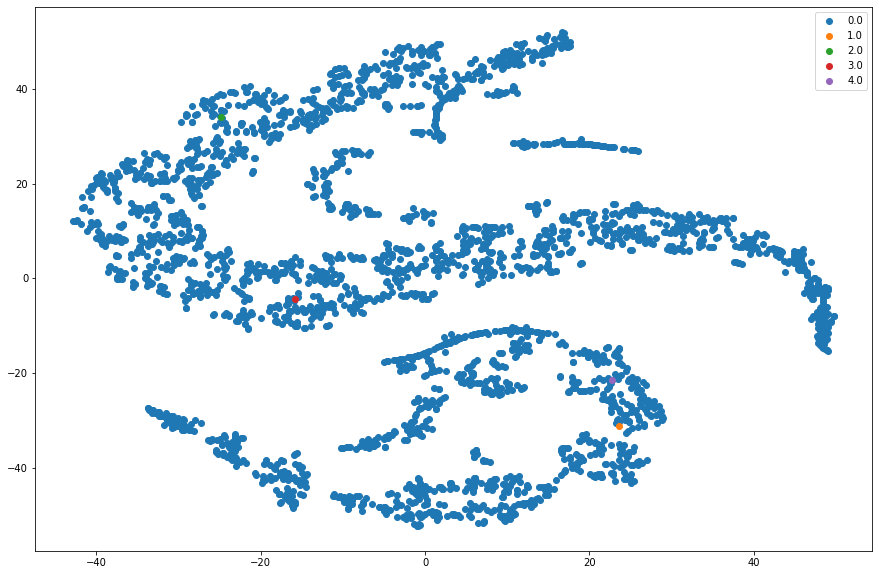

In [121]:
groups = tsne_df.groupby('cluster')

fig, ax = plt.subplots(figsize=(15, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group[0], group[1], marker='o', linestyle='', label=name)
ax.legend()
plt.show()

# *References*

- https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
- https://medium.com/@rumman1988/clustering-categorical-and-numerical-datatype-using-gower-distance-ab89b3aa90d9
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://www.google.com/search?client=firefox-b-d&q=python+gower+distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://discuss.analyticsvidhya.com/t/clustering-technique-for-mixed-numeric-and-categorical-variables/6753
- https://stackoverflow.com/questions/24196897/r-distance-matrix-and-clustering-for-mixed-and-large-dataset
- https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://rpubs.com/data_feelings/msda_data621_hw4
- https://pypi.org/project/gower/
- https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
- https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05
- https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/pam
- https://github.com/annoviko/pyclustering/issues/499
- https://stats.stackexchange.com/questions/2717/clustering-with-a-distance-matrix
- https://www.kaggle.com/fabiendaniel/customer-segmentation
- https://dkopczyk.quantee.co.uk/claim-prediction/
- https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf
- https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4
